# Libraries

In [1]:
from fastai.vision.all import *

# Color conversion

In [2]:
import os
from pathlib import Path

path = Path(r'D:\github\geoeyeai\cell_data')
train_path = path / 'train'
masks_path = path / 'masks'

print(f"📊 VERIFICADOR FINAL: {path}")
print("-" * 50)

imagens = [f for f in train_path.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
mascaras_arquivos = [f.name for f in masks_path.iterdir()]

print(f"📸 Imagens: {len(imagens)}")
print(f"🎭 Máscaras: {len(mascaras_arquivos)}")
print("-" * 50)

erros = 0
sucessos = 0

print("🔍 Verificando...")

for img in imagens:
    # A REGRA CORRETA AGORA:
    # Pega o nome do arquivo (stem) e só adiciona .png
    nome_esperado_mascara = img.stem + '.png'
    
    if nome_esperado_mascara in mascaras_arquivos:
        sucessos += 1
    else:
        erros += 1
        print(f"❌ ERRO: {img.name}")

print("-" * 50)
if erros == 0:
    print(f"✅ SUCESSO ABSOLUTO! {sucessos} pares encontrados.")
    print("🚀 Pode iniciar o treinamento sem medo.")
else:
    print(f"⚠️ Ainda temos {erros} erros.")

📊 VERIFICADOR FINAL: D:\github\geoeyeai\cell_data
--------------------------------------------------
📸 Imagens: 1516
🎭 Máscaras: 1525
--------------------------------------------------
🔍 Verificando...
--------------------------------------------------
✅ SUCESSO ABSOLUTO! 1516 pares encontrados.
🚀 Pode iniciar o treinamento sem medo.


In [ ]:
import numpy as np
from fastai.vision.all import *
from pathlib import Path
import PIL
import torch # Importante para checar a GPU

# ==============================================================================
# 0. CHECK-UP DE GPU (NOVO BLOCO) 🚀
# ==============================================================================
print("🔍 Verificando Hardware...")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ SUCESSO! GPU Detectada: {gpu_name}")
    print(f"🧠 Memória de Vídeo (VRAM): {vram:.2f} GB")
    
    # Força o FastAI a usar a GPU 0 (caso tenha mais de uma)
    torch.cuda.set_device(0)
else:
    print("⚠️ PERIGO: Nenhuma GPU detectada!")
    print("🐢 O treino rodará na CPU (Processador) e será EXTREMAMENTE LENTO.")
    print("   Verifique se instalou a versão do PyTorch com suporte a CUDA.")

print("-" * 50)

🔍 Verificando Hardware...
⚠️ PERIGO: Nenhuma GPU detectada!
🐢 O treino rodará na CPU (Processador) e será EXTREMAMENTE LENTO.
   Verifique se instalou a versão do PyTorch com suporte a CUDA.
--------------------------------------------------


: 

In [ ]:
import numpy as np
from fastai.vision.all import *
from pathlib import Path
import PIL
import torch

# ==============================================================================
# 0. CHECK-UP DE HARDWARE 🚀
# ==============================================================================
print("🔍 Verificando Hardware...")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ SUCESSO! GPU Detectada: {gpu_name}")
    print(f"🧠 Memória de Vídeo (VRAM): {vram:.2f} GB")
    torch.cuda.set_device(0)
else:
    print("⚠️ PERIGO: Nenhuma GPU detectada! O treino será lento.")

print("-" * 50)

# ==============================================================================
# 1. CONFIGURAÇÃO DOS CAMINHOS E CORES
# ==============================================================================
path = Path(r'D:\github\geoeyeai\cell_data')

# ⚠️ SEUS VALORES DE PIXEL (Cinzento -> ID da Classe)
pixel_map = {
    82:  1,  # Agua
    222: 2,  # Erosao
    # 125: 3,  # Ruptura
    # 151: 4   # Trinca
}

# Nomes das classes (0 é sempre Background/Fundo)
meus_codes = ['Background', 'Agua', 'Erosao']#, 'Ruptura', 'Trinca']

# ==============================================================================
# 2. FUNÇÕES AUXILIARES (Conversão e Busca)
# ==============================================================================
def mask_converter(arquivo_da_mascara):
    # Função que abre a máscara e troca as cores pelos IDs (0, 1, 2, 3, 4)
    if not Path(arquivo_da_mascara).exists():
        print(f"⚠️ Máscara não encontrada: {arquivo_da_mascara}")
        return PILMask.create(np.zeros((512,512), dtype=np.uint8))

    mask = PILMask.create(arquivo_da_mascara)
    mask_np = np.array(mask)
    
    # Cria máscara vazia (tudo zero/background)
    new_mask = np.zeros_like(mask_np, dtype=np.uint8)
    
    # Pinta os pixels
    for cor_original, novo_id in pixel_map.items():
        # Tolerância de +/- 5
        match = (mask_np >= cor_original - 5) & (mask_np <= cor_original + 5)
        new_mask[match] = novo_id
        
    return PILMask.create(new_mask)

def get_y_fn(x):
    # Transforma caminho da imagem em caminho da máscara
    folder_masks = x.parent.parent / 'maskss'
    nome_arquivo = x.stem + '.png'
    path_final = folder_masks / nome_arquivo
    return mask_converter(str(path_final))

# ==============================================================================
# 3. MÉTRICA PERSONALIZADA (A CORREÇÃO DO ERRO) 🛠️
# ==============================================================================
def pixel_accuracy(inp, targ):
    # Calcula acurácia pixel a pixel, ignorando dimensões extras
    targ = targ.squeeze(1) 
    return (inp.argmax(dim=1) == targ).float().mean()

# ==============================================================================
# 4. O DATABLOCK E LEARNER
# ==============================================================================
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=meus_codes)),
    get_items=get_image_files, 
    get_y=get_y_fn,            
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=[Resize(512)],   
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

print("⏳ Carregando dados... (Isso processa as máscaras, aguarde)")

# num_workers=0 é CRÍTICO no Windows para evitar travamentos
dls = dblock.dataloaders(path / 'trainn', bs=8, num_workers=0)

# Mostra um lote antes de começar
dls.show_batch(max_n=4)

# Define métricas
metrics = [DiceMulti, pixel_accuracy]

learn = unet_learner(dls, resnet34, metrics=metrics)

print("🚀 Começando o treino...")

# Treina
# Use learn.fine_tune(10) se tiver tempo, ou (4) para testar rápido
with learn.no_bar():
    learn.fine_tune(10)

# Mostra resultado final
learn.show_results(max_n=4, figsize=(10,10))

🔍 Verificando Hardware...
⚠️ PERIGO: Nenhuma GPU detectada! O treino será lento.
--------------------------------------------------
⏳ Carregando dados... (Isso processa as máscaras, aguarde)
🚀 Começando o treino...
[0, 0.28719761967658997, 0.1890217363834381, 0.3225820626898148, 0.9375039339065552, '12:07']
[0, 0.13619138300418854, 0.112572081387043, 0.5525508346400659, 0.9666433334350586, '12:16']
[1, 0.1041572242975235, 0.13174240291118622, 0.5553014292937394, 0.9687883853912354, '12:14']
[2, 0.11252055317163467, 0.11715273559093475, 0.5423963800479056, 0.9647820591926575, '12:30']
[3, 0.09596513956785202, 0.1337844431400299, 0.5583848232977711, 0.969525933265686, '12:11']
[4, 0.08155063539743423, 0.13258589804172516, 0.5595527296474636, 0.9690924286842346, '12:19']


In [ ]:
# 1. Avisa pro learner que o "caminho de casa" é AQUI (pasta atual)
learn.path = Path('.')

# Salva tudo no arquivo 'meu_modelo.pkl'
learn.export('meu_modelo.pkl')

print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


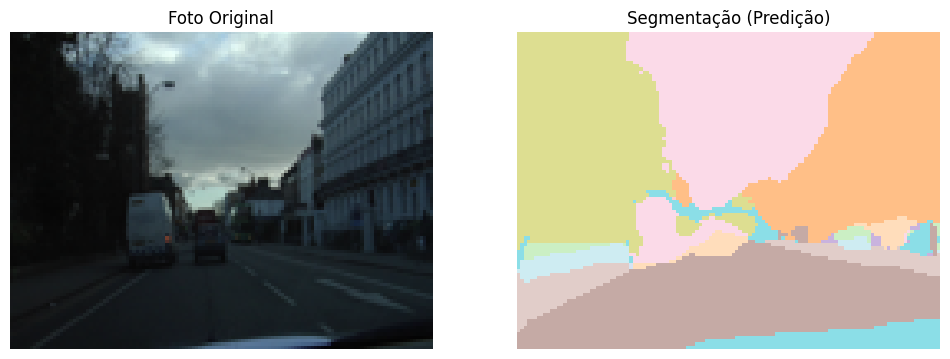

In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt

# --- A. Carregar o Modelo (Se você tiver fechado o notebook) ---
# Se você ainda está com o 'learn' na memória, pule essa linha.
# Se abriu um notebook novo, use isso:
learn_inf = load_learner('meu_modelo.pkl')

# --- B. Escolher uma imagem para testar ---
# Vamos pegar uma aleatória do dataset de validação para garantir que funciona
img_path = get_image_files(path/'train')[2]
# OU use uma imagem sua:
# img_path = 'minha_foto_da_rua.jpg'

# --- C. O comando Mágico: Predict ---
# Ele retorna 3 coisas:
# 1. pred_mask: A imagem da máscara já pronta (bonitinha)
# 2. pred_idx: A máscara em números (tensor com 0, 1, 2...)
# 3. probs: As probabilidades de certeza para cada pixel
pred_mask, pred_idx, probs = learn_inf.predict(img_path)

# --- D. Ver o Resultado ---
# Vamos plotar lado a lado: Imagem Original vs O que a IA viu
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Lado Esquerdo: Foto Original
img = PILImage.create(img_path)
img.show(ctx=ax[0], title='Foto Original')

# Lado Direito: O que o modelo pintou
pred_mask.show(ctx=ax[1], title='Segmentação (Predição)')

plt.show()